In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf

import glob
from tqdm import tqdm
import os 
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
from torchvision import transforms, utils
from datetime import datetime

In [9]:
#GPU check
device = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    devcie = torch.device('cpu')
print("Using PyTroch version:", torch.__version__,'Device',device)

Using PyTroch version: 1.10.0+cu102 Device cuda


In [4]:
#data load
train_files = glob.glob('../radar_image_predict/data/train/*.npy')
len(train_files)

62735

In [5]:
#train data check
data_1st = np.load(train_files[0])
data_1st.shape

(120, 120, 5)

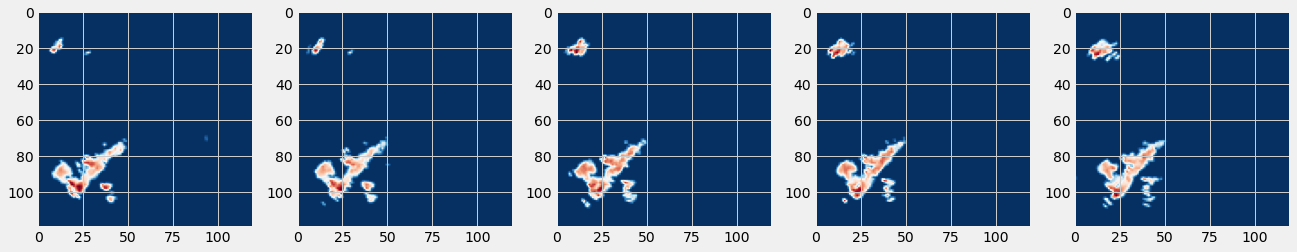

In [6]:
#data visualization
#colormap setting
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

#visualization
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20,20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(data_1st[:,:,i],cmap = color_map)

plt.subplot(1,5,5)
plt.imshow(data_1st[:,:,-1], cmap = color_map)
plt.show()

In [7]:
#path setting
default_path = '../radar_image_predict/'
data_path = '../radar_image_predict/data/'



In [8]:
#Data Loader

In [ ]:
#input으로 구름 radar이미지만 사용. t-30, t-20, t-10, t 의 4개 
#output은 t+10의 1개 이미지

class CloudDataset(Dataset):
    def __init__(self, df, train = True, transforms = None):
        
        """
        data_dir                => data folder path
        transform               => data to tensor
        data_type="train"       => choose train / valid / test
        frame_num               => frame nums to use on train 
        predict_num             => frame nums to predict
        stride_num              => stride for frames (if stride=2 => 197811.npy, 198001.npy, 198003.npy ... )
                                   만약 8월끼리 비교하고 싶다면 stride = 12 를 넣어준다.
        """
        
        self.df = df
        self.transforms = transfroms
        self.train = train
        
    def __len__(self):
        return len(self.X_train)
    
    
    def __getitem__(self, index):
        
        f_path = os.path.join('../radar_image_predict/data/train/', self.df.iloc[index]['file_name'])
        x = np.load(f_path)
        
        if self.transforms:
            x = self.transforms(x).reshape(1,1,120,120,1)
        
        if self.train:
            y = self.Y_train[index].reshape(1,1,120,120,1)
            return x,y
        else:
            return x

In [ ]:
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(1,1,120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4].reshape(1,1,120,120,1)

        yield (feature, remove_minus)
        
train_data = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([1,1,120,120,4]),tf.TensorShape([1,1,120,120,1])))

In [ ]:
train_data.